In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging, sys
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN

2024-04-12 22:22:14.428615: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 22:22:14.431318: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 22:22:14.461303: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 22:22:15.178611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_csv('./Google_Stock_Price_Train.csv')

In [4]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',drop=True,inplace=True)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float)
df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Close'] = df.apply(lambda x: x['Close']/2 if x['Close'] > x['High'] else x['Close'], axis=1)

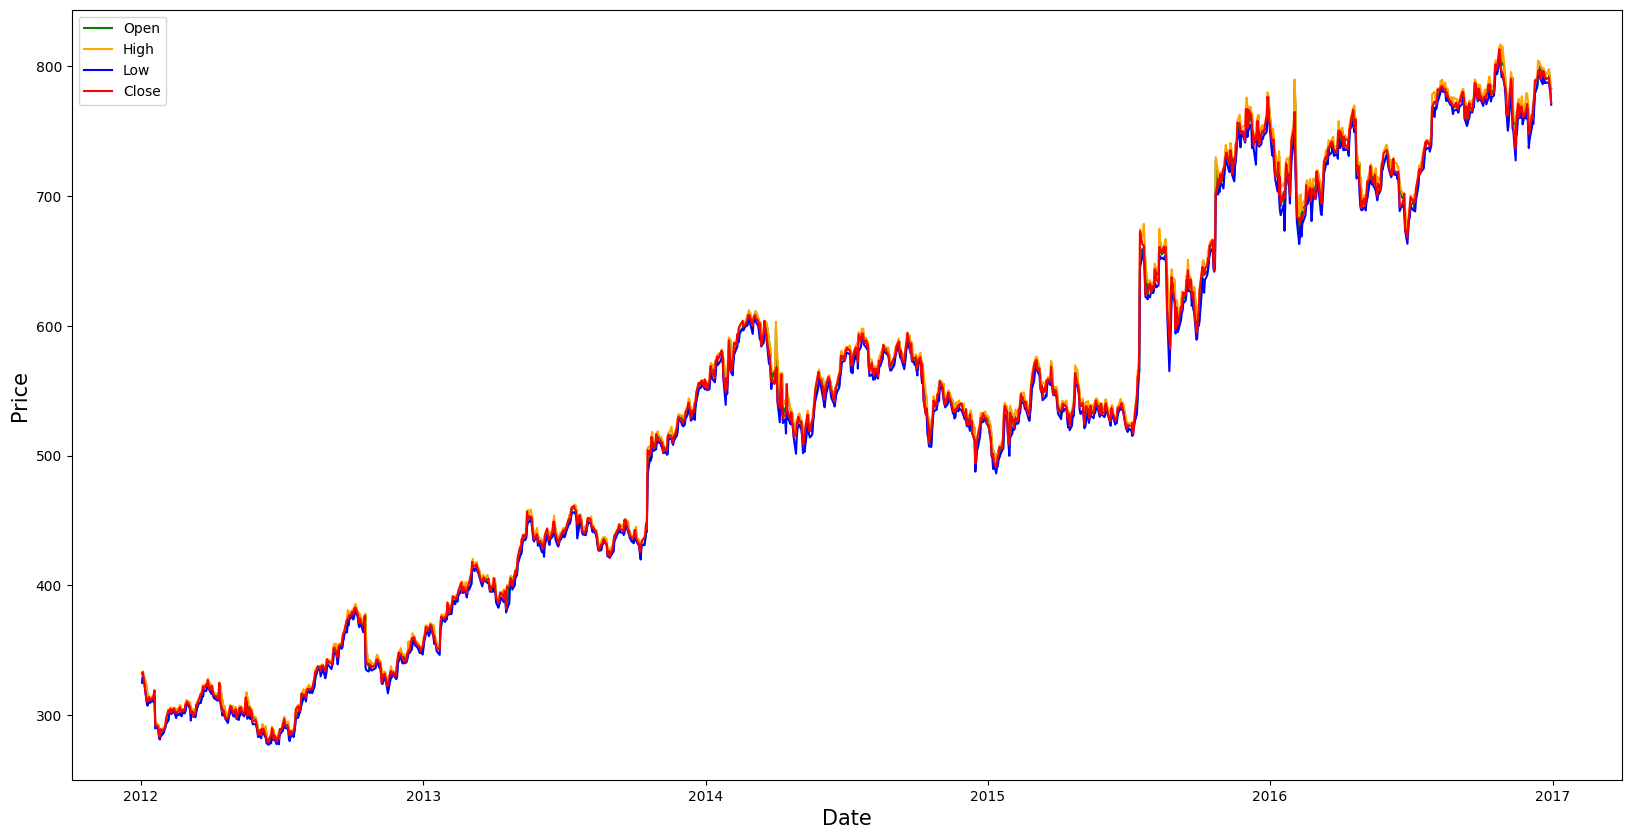

In [5]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df['Open'], label='Open', color='green')
ax.plot(df['High'], label='High', color='orange')
ax.plot(df['Low'],label='Low',color='blue')
ax.plot(df['Close'],label='Close',color='red')
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Price',size=15)
ax.legend()

fig.show()

In [6]:
predictors = ['Close']

# Drop all columns except predictors
df = df[predictors]

MMS = MinMaxScaler()
df[df.columns] = MMS.fit_transform(df)

# Split data into train, validation, and test sets
split_data = np.split(df, [int(.7*len(df)), int(.85*len(df))])
# Convert data splits into NumPy arrays
train_x, valid_x, test_x = [d[predictors].to_numpy() for d in split_data]

train_x.shape, valid_x.shape, test_x.shape

((880, 1), (189, 1), (189, 1))

In [7]:
def create_sequence(dataset):
    sequences = []
    labels = []
    for i in range(len(dataset) - 50):  # Loop until 50 elements from the end
        sequences.append(dataset[i:i+50])
        labels.append(dataset[i+50])
    return np.array(sequences), np.array(labels)

# Call the function for train, validation, and test sets
train_seq, train_label = create_sequence(train_x)
valid_seq, valid_label = create_sequence(valid_x)
test_seq, test_label = create_sequence(test_x)
train_seq.shape, train_label.shape, valid_seq.shape, valid_label.shape, test_seq.shape, test_label.shape

((830, 50, 1), (830, 1), (139, 50, 1), (139, 1), (139, 50, 1), (139, 1))

In [8]:
model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1)) 
model.add(SimpleRNN(units=50))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

2024-04-12 22:22:17.126808: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 22:22:17.127287: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50, 100)        │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,801 (69.54 KB)

 Trainable params: 17,801 (69.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_seq, train_label, epochs=50,validation_data=(valid_seq, valid_label), verbose=1)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2530 - mean_absolute_error: 0.3686 - val_loss: 0.0040 - val_mean_absolute_error: 0.0550
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099 - mean_absolute_error: 0.0773 - val_loss: 0.0035 - val_mean_absolute_error: 0.0509
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - mean_absolute_error: 0.0518 - val_loss: 0.0042 - val_mean_absolute_error: 0.0575
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0431 - val_loss: 0.0027 - val_mean_absolute_error: 0.0448
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_absolute_error: 0.0395 - val_loss: 0.0052 - val_mean_absolute_error: 0.0651
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_absolute_error: 0.0346 - val_loss: 0.0032 - val_mean_absolute_error: 0.0492
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0299 - val_loss: 0.00

In [ ]:
plt.plot(history.history['loss'], label='loss', color='green')
plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error', color='orange')
plt.plot(history.history['val_loss'], label='val_loss', color='blue')
plt.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error', color='red')
plt.show()

In [ ]:
test_predicted = model.predict(test_seq)

# Inversing scaling on predicted data
test_inverse_predicted = MMS.inverse_transform(test_predicted) 
test_inverse_label = MMS.inverse_transform(test_label)

In [ ]:
plt.plot(test_inverse_predicted, label='Predicted', color='red')
plt.plot(test_inverse_label, label='Actual', color='blue')

plt.ylabel('Value')
plt.title('Predicted vs Actual Close')

plt.legend()
plt.show()

In [ ]:
test_inverse_predicted[:5]

In [ ]:
test_inverse_label[:5]